In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import cupy as cp
import os
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

# Init data sizes and parametes of the PXM of ID16A

In [2]:
# energy = float(sys.argv[1])  # [keV] xray energy
# z1p = float(sys.argv[2])# positions of the probe and code for reconstruction
# # z1p = 270e-3# positions of the probe and code for reconstruction
# ill_feature_size = float(sys.argv[3])
# use_prb = sys.argv[4]=='True'
# use_code = sys.argv[5]=='True'
# ndist = int(sys.argv[6])
# smooth = int(sys.argv[7])
###################
energy = 33.35  # [keV] xray energy
z1p = 20e-3# positions of the probe and code for reconstruction
ill_feature_size = 1e-6
use_prb = False
use_code = True
ndist = 1
smooth = 1
code_thickness = 20e-6
flg_show = True
###################
pad=False#True

ne=256
n = 256  # object size in each dimension
ntheta = 360  # number of angles (rotations)
pn = 256  # tomography chunk size for GPU processing
ptheta = 360 # holography chunk size for GPU processing
center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

flg = f'{n}_{ntheta}_{energy:.2f}_{z1p:.1e}_{ill_feature_size:.1e}_{use_prb}_{use_code}_{ndist}_{smooth}_{code_thickness:.2e}'
print(flg)

wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28
# sx0 = 3.7e-4
# z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
sx0 = 5.9e-4
z1 = 1.5*np.array([13.232e-3,13.774e-3,15.944e-3,20.448e-3])[:ndist]-sx0
z1[:] = z1[0]

z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

voxelsize = 0.5*3e-6/magnifications[0]*2048/n  # object voxel size

z2p = z1-z1p
# magnification when propagating from the probe plane to the detector
magnificationsp = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/z1

norm_magnificationsp = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2
print(voxelsize)
print(distances, distancesp)
print(distances+ distancesp)


256_360_33.35_2.0e-02_1.0e-06_False_True_2_1_1.00e-05
1.8054375000000002e-07
[0.01896826 0.01896826] [-0.00071447 -0.00071447]
[0.01825379 0.01825379]


## Read real and imaginary parts of the refractive index u = delta+i beta

2.071661502345279e-07 9.634532228012238e-11 2150.246066251103
2.9839802972997376e-07 3.224279760663861e-10 925.4718941278695
1.395387139169202e-10 4.686360040313982e-15 29775.5001144921
1.8644953514446172e-07 8.671079005211015e-11 2150.246065482878
2.071661502345279e-07 9.634532228012238e-11 2150.246066251103


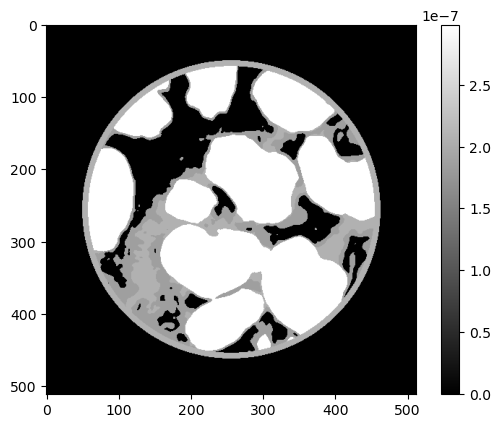

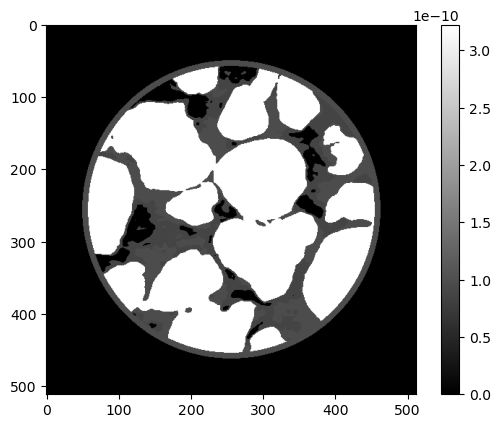

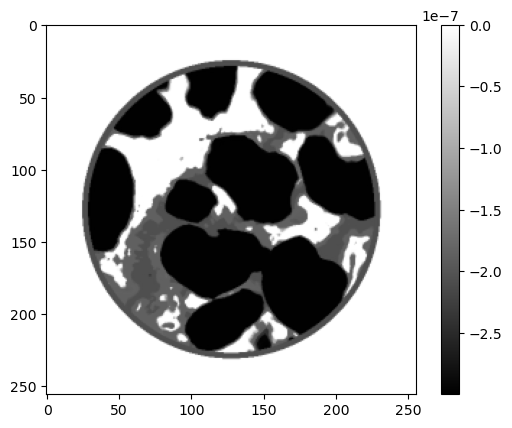

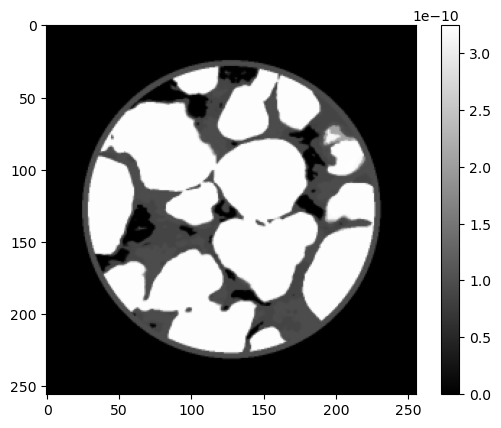

In [3]:
import xraylib
ut = dxchange.read_tiff('/data/part512x512x512.tif').copy()
[x,y,z] = np.meshgrid(np.arange(-256,256)/256,np.arange(-256,256)/256,np.arange(-256,256)/256)
circ = x**2+y**2+z**2<0.6
[x,y] = np.meshgrid(np.arange(-256,256)/256,np.arange(-256,256)/256)
# circ *= x**2+y**2<0.5
ut*=circ

[x,y,z] = np.meshgrid(np.arange(-256,256)/256,np.arange(-256,256)/256,np.arange(-256,256)/256)
circ = x**2+y**2+z**2<0.65
[x,y] = np.meshgrid(np.arange(-256,256)/256,np.arange(-256,256)/256)
# circ *= x**2+y**2<0.55

# ut[:64]=0
# ut[-64:]=0

u = np.zeros([512,512,512],dtype='complex64')
# circ = x**2+y**2<0.53
delta = 1-xraylib.Refractive_Index_Re('H2O',energy,1)
beta = xraylib.Refractive_Index_Im('H2O',energy,1)
u[circ] = delta+1j*beta
print(delta,beta,delta/beta)


# u[:60]=0
# u[-60:]=0
#1
delta = 1-xraylib.Refractive_Index_Re('SiO2',energy,1.6)
beta = xraylib.Refractive_Index_Im('SiO2',energy,1.6)
print(delta,beta,delta/beta)
u[ut==1] = delta+1j*beta

#2
delta = 1-xraylib.Refractive_Index_Re('CH4',energy,0.0006)
beta = xraylib.Refractive_Index_Im('CH4',energy,0.00006)
print(delta,beta,delta/beta)
u[ut==2] = delta+1j*beta

#34
delta = 1-xraylib.Refractive_Index_Re('H2O',energy,0.9)
beta = xraylib.Refractive_Index_Im('H2O',energy,0.9)
print(delta,beta,delta/beta)
u[ut==3] = delta+1j*beta
u[ut==4] = delta+1j*beta

#5
delta = 1-xraylib.Refractive_Index_Re('H2O',energy,1)
beta = xraylib.Refractive_Index_Im('H2O',energy,1)
print(delta,beta,delta/beta)
u[ut==5] = delta+1j*beta

plt.imshow(u[256].real,cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(u[:,256].imag,cmap='gray')
plt.colorbar()
plt.show()

u = u[::2]+u[1::2]
u = u[:,::2]+u[:,1::2]
u = u[:,:,::2]+u[:,:,1::2]
u/=8

v = np.arange(-n//2,n//2)/n
[vx,vy,vz] = np.meshgrid(v,v,v)
v = np.exp(-1*(vx**2+vy**2+vz**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u)))
u = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).astype('complex64')

u[np.where(u.real<0)] = 0
u = -u.real+1j*u.imag
u = u.astype('complex64')#.get()
plt.imshow(u[128].real,cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(u[:,128].imag,cmap='gray')
plt.colorbar()
plt.show()


In [4]:
# from scipy import ndimage

# cube_all = np.zeros([n,n,n],dtype='float32')
# rr = (np.ones(8)*n*0.25).astype(np.int32)
# amps = [3, -3, 1, 3, -4,1,4]#, -2, -4, 5 ]
# dil = np.array([33, 28, 25, 21, 16,10,3])/256*n#, 6, 3,1]
# for kk in range(len(amps)):
#     cube = np.zeros([n,n,n],dtype='bool')
#     r = rr[kk]
#     p1 = n//2-r//2
#     p2 = n//2+r//2
#     for k in range(3):    
#         cube = cube.swapaxes(0,k)
#         cube[p1:p2,p1,p1] = True
#         cube[p1:p2,p1,p2] = True
#         cube[p1:p2,p2,p1] = True
#         cube[p1:p2,p2,p2] = True        
#         #cube[p1:p2,p2,p2] = True        
        
#     [x,y,z] = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2),np.arange(-n//2,n//2))
#     circ = (x**2+y**2+z**2)<dil[kk]**2  
#     # circ = (x**2<dil[kk]**2)*(y**2<dil[kk]**2)*(z**2<dil[kk]**2)
          
#     fcirc = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(circ)))
#     fcube = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(cube.astype('float32'))))
#     cube = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fcube*fcirc))).real
#     cube = cube>1
#     cube_all+=amps[kk]*cube

# # cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=1)
# cube_all = ndimage.rotate(cube_all,28,axes=(0,1),reshape=False,order=3)
# cube_all = ndimage.rotate(cube_all,45,axes=(0,2),reshape=False,order=3)
# cube_all[cube_all<0] = 0



# u0 = (-1*cube_all*1e-6+1j*cube_all*1e-8)/3

# # u0 = (-1*cube_all*2.863698115973534e-06+1j*cube_all*1.1906916589949026e-07)
# #2.863698115973534e-06 1.1906916589949026e-07

# u0=np.roll(u0,-15*n//256,axis=2)
# u0=np.roll(u0,-10*n//256,axis=1)
# v = np.arange(-n//2,n//2)/n
# [vx,vy,vz] = np.meshgrid(v,v,v)
# v = np.exp(-15*(vx**2+vy**2+vz**2))
# fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u0)))
# u0 = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).astype('complex64')

# u = u0.astype('complex64')#.get()

# fig, ax = plt.subplots(1, figsize=(3, 3))#fig, ax = plt.subplots(1, figsize=(3, 3))
# plt.imshow(-u0[n//2].real,cmap='gray')#,vmax=2.526992e-06,vmin=0)
# plt.colorbar()
# ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.savefig('figs/deltah.png',dpi=300,bbox_inches='tight')
# plt.show()
# # # sss

# fig, ax = plt.subplots(1, figsize=(3, 3))#fig, ax = plt.subplots(1, figsize=(3, 3))
# plt.imshow(-u0[n//2].real,cmap='gray')#,vmax=2.526992e-06,vmin=0)
# plt.colorbar()
# ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.savefig('figs/deltah_rot.png',dpi=300,bbox_inches='tight')
# plt.show()

# fig, ax = plt.subplots(1, figsize=(3, 3))#fig, ax = plt.subplots(1, figsize=(3, 3))
# plt.imshow(-u0[:,n//2-8].real,cmap='gray')
# plt.colorbar()
# ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.savefig('figs/deltav_rot.png',dpi=300,bbox_inches='tight')
# plt.show()
# # fig, ax = plt.subplots(1, figsize=(3, 3))
# # plt.imshow(u0[n//2].imag.get(),cmap='gray')
# # plt.colorbar()
# # plt.savefig('figs/betah_rot.png',dpi=300,bbox_inches='tight')
# # plt.show()
# # fig, ax = plt.subplots(1, figsize=(3, 3))
# # plt.imshow(-u0[:,n//2].real.get(),cmap='gray',vmax=2.526992e-06,vmin=0)
# # plt.colorbar()
# # plt.savefig('figs/deltav_rot.png',dpi=300,bbox_inches='tight')
# # plt.show()
# # fig, ax = plt.subplots(1, figsize=(3, 3))
# # plt.imshow(u0[:,n//2].imag.get(),cmap='gray')
# # plt.colorbar()
# # plt.savefig('figs/betav_rot.png',dpi=300,bbox_inches='tight')
# # plt.show()



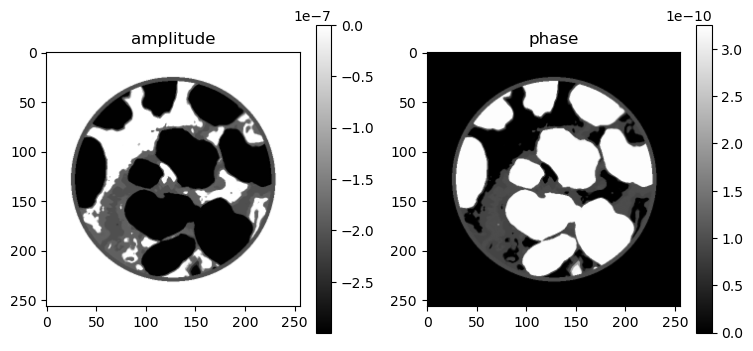

In [5]:
if flg_show:    
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(cp.real(u[n//2]).get(),cmap='gray')
    axs[0].set_title('amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(cp.imag(u[n//2]).get(),cmap='gray')
    axs[1].set_title('phase')
    fig.colorbar(im)

0.9629
48
2.619316059604415e-07 1.1090663847733014e-10 2361.7306371969935
[0.01896826 0.01896826] [-0.00071447 -0.00071447]
[0.01825379 0.01825379]


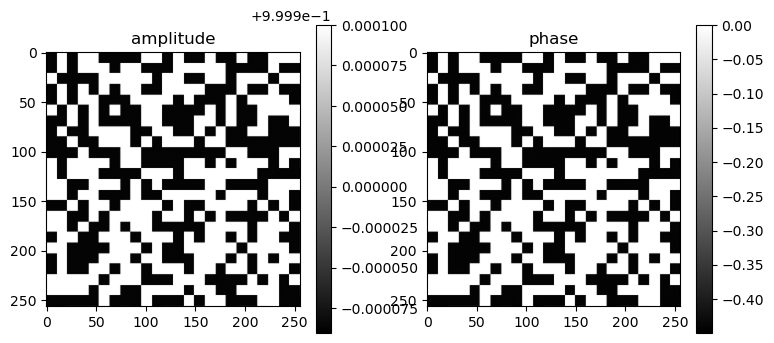

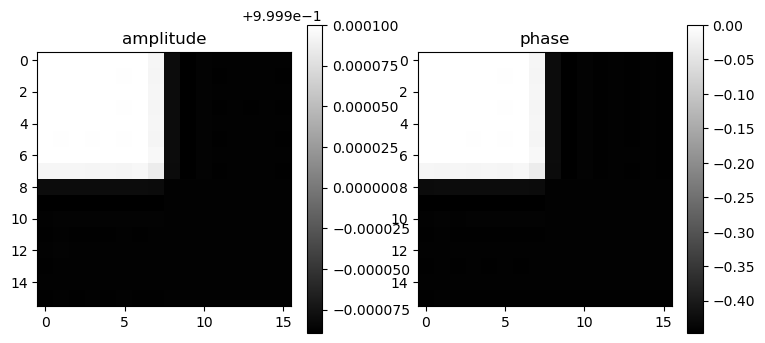

In [6]:
import random
import xraylib
random.seed(10)
nill = 2**8
ill_global = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = np.zeros([nill*nill],dtype='bool')
    ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)

# form codes for simulations

print(magnificationsp[0])
nill = int(ne*voxelsize/magnificationsp[0]//(ill_feature_size*2))*2
print(nill)
ill = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
    
ill = ndimage.zoom(ill,[1,2*n/nill,2*n/nill],order=0,grid_mode=True,mode='grid-wrap')

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

delta = 1-xraylib.Refractive_Index_Re('C22H10N205',energy,1.4)
beta = xraylib.Refractive_Index_Im('C22H10N205',energy,1.4)

# C22H10N205

print(delta,beta,delta/beta)
thickness = code_thickness/voxelsize # thickness in pixels

v = np.arange(-2*n//2,2*n//2)/2/n
[vx,vy] = np.meshgrid(v,v)
v=np.exp(-smooth*(vx**2+vy**2))
fill = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(ill)))
ill = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fill*v)))
ill = ill.astype('complex64')
ill[ill<0] = 0

# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
psiill = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')

if use_code==False:
    psiill[:]=1

if flg_show:    
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(np.abs(psiill[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
    axs[0].set_title('amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(psiill[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
    axs[1].set_title('phase')
    fig.colorbar(im)
print(distances, distancesp)
print(distances+ distancesp)
if flg_show:    
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(np.abs(psiill[0,n-n//32:n+n//32,n-n//32:n+n//32]),cmap='gray')
    axs[0].set_title('amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(psiill[0,n-n//32:n+n//32,n-n//32:n+n//32]),cmap='gray')
    axs[1].set_title('phase')
    fig.colorbar(im)


In [7]:
shifts_code = np.round((np.random.random([ndist, ntheta, 2])-0.5)*n/2).astype('float32')

In [8]:
prb = np.zeros([ndist,n,n],dtype='complex64')
for k in range(ndist):
    prb_abs = dxchange.read_tiff(f'../gh/data/prb_syn_abs_{n}_{k}.tiff')
    prb_phase = dxchange.read_tiff(f'../gh/data/prb_syn_angle_{n}_{k}.tiff')
    prb[k] = prb_abs*np.exp(1j*prb_phase).astype('complex64')      
prb[:] = prb[0]    

# prb_abs = dxchange.read_tiff(f'/data/vnikitin/modeling/prb_abs_gh_codes_256_180_33.35_1.0e-02_1.0e-06_False_True_4_2_1.00e-06.tiff')#[0:ndist]
# prb_phase = dxchange.read_tiff(f'/data/vnikitin/modeling/prb_angle_gh_codes_256_180_33.35_1.0e-02_1.0e-06_False_True_4_2_1.00e-06.tiff')#[0:ndist]
# prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')
# print(np.linalg.norm(prb))#.shape)

if use_prb == False:
    prb[:] = 1


Note that in this formation delta is negative

## Create a solver class for tomography, use double sizes

In [9]:
tslv = holotomo.SolverTomo(theta, ntheta, n, n, pn, center)

note pn parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pn=n. If the gpu does not have enough memory then pn should  be decreased

## Create a solver class for holography

In [10]:
pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

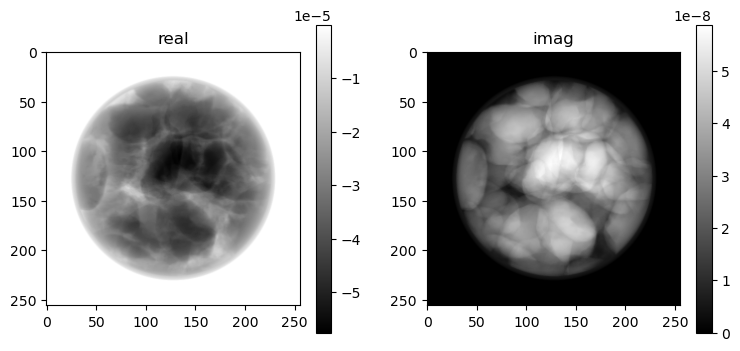

In [11]:
Ru = tslv.fwd_tomo_batch(u)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.real(Ru[0]),cmap='gray')
axs[0].set_title('real')
fig.colorbar(im)
im=axs[1].imshow(np.imag(Ru[0]),cmap='gray')
axs[1].set_title('imag')
fig.colorbar(im)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

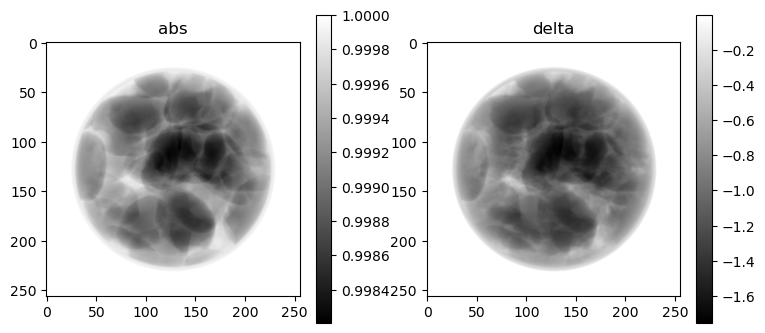

In [12]:
psi0 = pslv.exptomo(Ru)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi0[0]),cmap='gray')
axs[0].set_title('abs')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi0[0]),cmap='gray')
axs[1].set_title('delta')
fig.colorbar(im)

# Compute holographic projections for all angles and all distances

In [13]:
shifts = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/16*0#*norm_magnifications[:,np.newaxis,np.newaxis]
shifts_ref = shifts/norm_magnifications[:,np.newaxis,np.newaxis]
psi = np.pad(psi0,((0,0),((ne-n)//2,(ne-n)//2),((ne-n)//2,(ne-n)//2)),'edge')
prb = prb.copy()
fpsi = pslv.fwd_holo_batch(psi,prb,shifts_ref,psiill,shifts_code)
fpsi0 = pslv.fwd_holo_batch(psi,prb*0+1,shifts_ref,psiill,shifts_code) # ignore probe

pslv0 = holotomo.SolverHolo(1, n, ne, 1, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad) 
fref = pslv0.fwd_holo_batch(psi[:1]*0+1,prb,shifts_ref[:,:1]*0,psiill,shifts_code[:,:1]*0) # ignore sample

## Take squared absolute value to simulate data on the detector, ref fields, and data with homogeneous ref fields  

In [14]:
data = np.abs(fpsi)**2
data_ref = np.abs(fref)**2
data0 = np.abs(fpsi0)**2

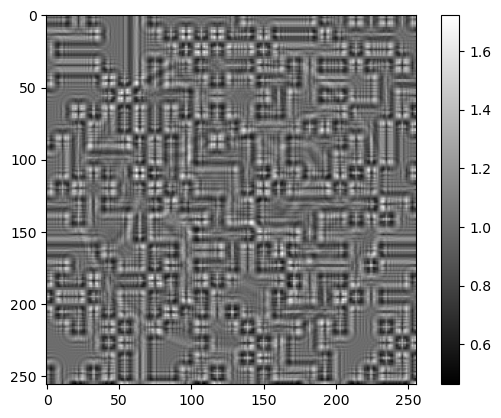

In [15]:
if flg_show:
    plt.imshow(data[0,0],cmap='gray')
    plt.colorbar()

In [16]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k],f'/data/vnikitin/modeling/data_gh_codes_{flg}_{k}',overwrite=True)
    dxchange.write_tiff(data_ref[k,0],f'/data/vnikitin/modeling/ref_gh_codes_{flg}_{k}',overwrite=True)
dxchange.write_tiff(np.abs(psi),f'/data/vnikitin/modeling/psi_abs_gh_codes_{flg}',overwrite=True)
dxchange.write_tiff(np.angle(psi),f'/data/vnikitin/modeling/psi_angle_gh_codes_{flg}',overwrite=True)


dxchange.write_tiff(np.abs(psiill),f'/data/vnikitin/modeling/psiill_abs_{flg}',overwrite=True)
dxchange.write_tiff(np.angle(psiill),f'/data/vnikitin/modeling/psiill_angle_{flg}',overwrite=True)

dxchange.write_tiff(np.abs(prb),f'/data/vnikitin/modeling/prb_abs_{flg}',overwrite=True)
dxchange.write_tiff(np.angle(prb),f'/data/vnikitin/modeling/prb_angle_{flg}',overwrite=True)

dxchange.write_tiff(np.real(u.real),f'/data/vnikitin/modeling/u_{flg}',overwrite=True)

np.save(f'/data/vnikitin/modeling/shifts_{flg}',shifts)
np.save(f'/data/vnikitin/modeling/shifts_code_{flg}',shifts_code)
print(flg)

256_360_33.35_2.0e-02_1.0e-06_False_True_2_1_1.00e-05


In [17]:
f'/data/vnikitin/modeling/psiill_abs_{flg}'



'/data/vnikitin/modeling/psiill_abs_256_360_33.35_2.0e-02_1.0e-06_False_True_2_1_1.00e-05'